In [1]:
# Data manipulation
# ==============================================================================
import warnings
import shap
from skforecast.utils import load_forecaster
from skforecast.utils import save_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import skforecast
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================


# Warnings configuration
# ==============================================================================
warnings.filterwarnings('once')

print('Skforecast version: ', skforecast.__version__)

c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skforecast version:  0.12.1


In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True)

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [3]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()
# data.head()
data

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


In [4]:
# Missing values
# ==============================================================================
print(
    f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')


# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()



Number of rows with missing values: 0.0


True

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


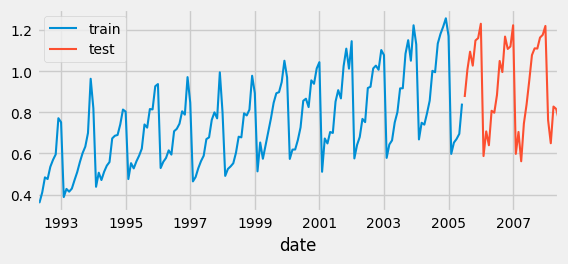

In [5]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend()

In [6]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=6
)
forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-06-03 15:20:19 
Last fit date: 2024-06-03 15:20:19 
Skforecast version: 0

In [7]:
# Last window
# ==============================================================================
last_window = forecaster.last_window
last_window

date
2005-01-01    1.170690
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [8]:
date_start_prediction = pd.to_datetime("2006-01-01")
# dummy_value = np.inf
dummy_value = np.random.rand()

last_window_extended = last_window.reindex(
    pd.date_range(start=last_window.index[0],
                  end=date_start_prediction, freq='MS'),
    fill_value=dummy_value
)

last_window_extended

2005-01-01    1.170690
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
2005-07-01    0.849588
2005-08-01    0.849588
2005-09-01    0.849588
2005-10-01    0.849588
2005-11-01    0.849588
2005-12-01    0.849588
2006-01-01    0.849588
Freq: MS, Name: y, dtype: float64

In [9]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=12, last_window=last_window_extended)
predictions.head(7)

2006-02-01    0.905835
2006-03-01    0.896152
2006-04-01    0.938707
2006-05-01    0.962492
2006-06-01    0.888809
2006-07-01    0.747324
2006-08-01    0.741838
Freq: MS, Name: pred, dtype: float64

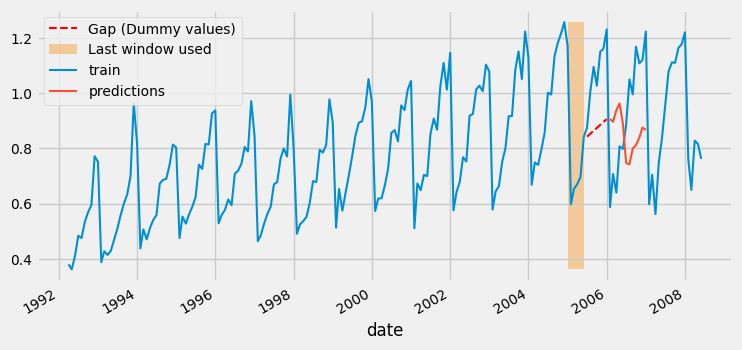

In [10]:
# Plot predictions
# ==============================================================================
last_window_used = (
    last_window_extended.index[0], last_window_extended.index[-8])
dummy_values = (last_window_extended.index[-7], last_window_extended.index[-1])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    [dummy_values[0], dummy_values[1]],
    [last_window.iloc[-1], predictions.iloc[0]],
    color='red',
    linestyle='--',
    label='Gap (Dummy values)'
)
ax.fill_between(last_window_used, data['y'].min(), data['y'].max(),
                facecolor='#f7931a', alpha=0.4, zorder=0, label='Last window used')
data['y'].plot(ax=ax, label='train')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [11]:
# Predictions
# ==============================================================================
predictions1 = forecaster.predict(steps=12)
predictions1.head(7)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
2005-12-01    0.714687
2006-01-01    0.746887
Freq: MS, Name: pred, dtype: float64

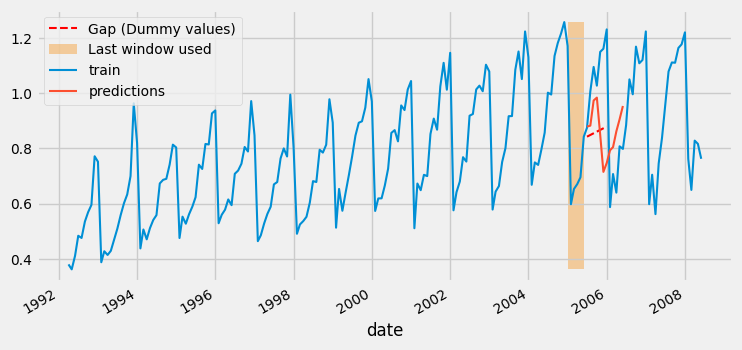

In [12]:
# Plot predictions
# ==============================================================================
last_window_used = (
    last_window_extended.index[0], last_window_extended.index[-8])
dummy_values = (last_window_extended.index[-7], last_window_extended.index[-1])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    [dummy_values[0], dummy_values[1]],
    [last_window.iloc[-1], predictions1.iloc[0]],
    color='red',
    linestyle='--',
    label='Gap (Dummy values)'
)
ax.fill_between(last_window_used, data['y'].min(), data['y'].max(),
                facecolor='#f7931a', alpha=0.4, zorder=0, label='Last window used')
data['y'].plot(ax=ax, label='train')
predictions1.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

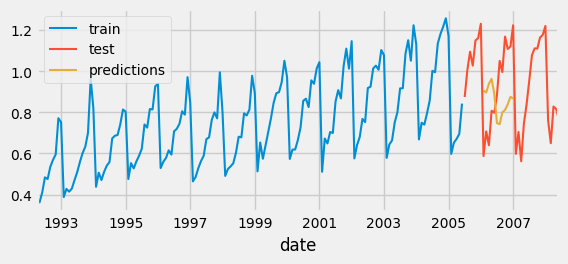

In [13]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [14]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
    y_true=data_test['y'],
    y_pred=predictions
)
print(f"Test error (MSE): {error_mse}")

ValueError: Found input variables with inconsistent numbers of samples: [36, 12]

In [ ]:
# Hyperparameters: grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=12  # This value will be replaced in the grid search
)

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 5, 10]
}

results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=data_train['y'],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=steps,
    refit=False,
    metric='mean_squared_error',
    initial_train_size=int(len(data_train)*0.5),
    fixed_train_size=False,
    return_best=True,
    n_jobs='auto',
    verbose=False
)

# Search results
# ==============================================================================
results_grid

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.02177319540541341



,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",0.021773,3,250
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 250}",0.021852,5,250
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 250}",0.021909,10,250
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.022530,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.022569,3,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.023400,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.063144,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 250}",0.064241,3,250
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.066307,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.067151,5,100


In [ ]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = RandomForestRegressor(
    n_estimators=250, max_depth=3, random_state=123)
forecaster = ForecasterAutoreg(
    regressor=regressor,
    lags=20
)
forecaster.fit(y=data_train['y'])

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

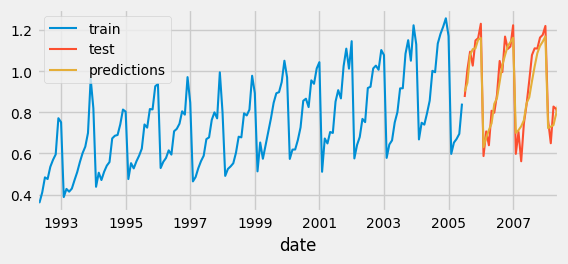

In [ ]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
    y_true=data_test['y'],
    y_pred=predictions
)
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.004356831371529945


In [ ]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3  # The last 9 years are separated for the backtest
metric, predictions_backtest = backtesting_forecaster(
    forecaster=forecaster,
    y=data['y'],
    initial_train_size=len(data) - n_backtesting,
    fixed_train_size=False,
    steps=steps,
    metric='mean_squared_error',
    refit=True,
    verbose=True,
    show_progress=True
)
print(f"Backtest metric (MSE): {metric}")

In [ ]:
# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data.loc[predictions_backtest.index, 'y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend()